In [1]:
%matplotlib inline
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from matplotlib.ticker import StrMethodFormatter

In [2]:
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   MaxAbsScaler,
                                   LabelEncoder)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import (cross_val_predict, 
                                     cross_val_score, 
                                     GridSearchCV, 
                                     StratifiedKFold, 
                                     StratifiedShuffleSplit)
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve, learning_curve

In [3]:
def plot_bin_scores(scores, ax):
    gb = scores.groupby(by="bin", as_index=False)
    scores_mean = gb.mean()["acc"]
    scores_std = gb.std()["acc"]
    num_bins = len(scores_mean)
    x = np.arange(num_bins)
    ax.plot(x, scores_mean)
    ax.fill_between(x, scores_mean - scores_std, 
                    scores_mean + scores_std, alpha=0.15)
    ax.set_xlabel('Bin number')
    ax.set_ylabel('Accuracy')
    ax.grid()
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
    return ax, scores_mean

In [4]:
def read_data(data_file):
    ve = pd.read_csv(data_file, header=None).transpose()
    new_header = ve.iloc[0]
    ve = ve[1:]
    ve.columns = new_header
    # 'EOG002', 'EOG003',
    if data_file.find('movcorr') != -1:
        ve = ve.drop(['EOG002', 'EOG003', 'STI016', 'STI101', 'STI102', 'SYS101', 'SYS201', 
                      'CHPI001', 'CHPI002', 'CHPI003', 'CHPI004', 'CHPI005',
                      'CHPI006', 'CHPI007', 'CHPI008', 'CHPI009'
                      ],
                     axis=1)
    else:
        ve = ve.drop(['EOG002', 'EOG003', 'STI016', 'STI101', 
                      'STI102', 'SYS101', 'SYS201'],
                     axis=1)        
    ve = ve.apply(pd.to_numeric, errors='ignore')    
    return ve

There are 7 pos in total. The one with 38 trial is control (0 degrees). Each pos has 20 t each. It make sense to collapse by hemifields: 45, 90 and 135 would be one hemifield (one category) and the others would be the other category.

The trials could be also paired by distance from 0. 45 and 315 would be one, other 90 and 180, and the other two the third.

# Classify all positions

In [5]:
n_trials = 40
bins_per_trial = 100
participant = 'p27_movcorr'

In [6]:
positions = ['45', '90', '135', '225', '270', '315']

In [7]:
pipeline = make_pipeline(StandardScaler(),
                         # PCA(n_components=.99, svd_solver='full'),
                         LogisticRegression(C=1, solver='liblinear', penalty='l1')
                         )
cvss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cvsk = StratifiedKFold(n_splits=10, random_state=42)

In [8]:
pos_data_dfs = {}
for pos in positions:
    pos_path = sorted(glob('data/position/{}/AllBins_{}*'.format(participant, pos)))
    pos_data_dfs[pos] = pd.concat([read_data(f_in) for f_in in pos_path])

In [9]:
pos_data = {}
for k, df in pos_data_dfs.items():
    pos_data[k] = (df
                   .iloc[:, df.columns.get_loc("MEG1521"):]
                   .values
                   .reshape(n_trials, bins_per_trial, -1))

In [10]:
sensor_names = pos_data_dfs['45'].columns[-pos_data['45'].shape[-1]:]

In [11]:
le = LabelEncoder()
bin_scores = {}
y = np.repeat(positions, n_trials)
y = le.fit_transform(y)
for b in range(bins_per_trial):
    X = np.vstack([pos_data[pos][:, b, :] for pos in positions])
    this_bin_scores = cross_val_score(pipeline, X, y, cv=cvsk, n_jobs=4)
    bin_scores[b] = this_bin_scores

In [12]:
scores = pd.melt(pd.DataFrame(bin_scores), var_name="bin", value_name="acc")

In [13]:
sorted_scores = (scores
                 .groupby(by="bin", as_index=False)
                 .mean()
                 .sort_values(by='acc', ascending=False)
                 .head(10)
                )

In [14]:
sorted_scores

bin       acc
56   56  0.545833
62   62  0.495833
63   63  0.479167
57   57  0.437500
64   64  0.433333
55   55  0.433333
65   65  0.433333
69   69  0.416667
61   61  0.404167
59   59  0.387500

In [15]:
best_bin = sorted_scores.bin.iloc[0]

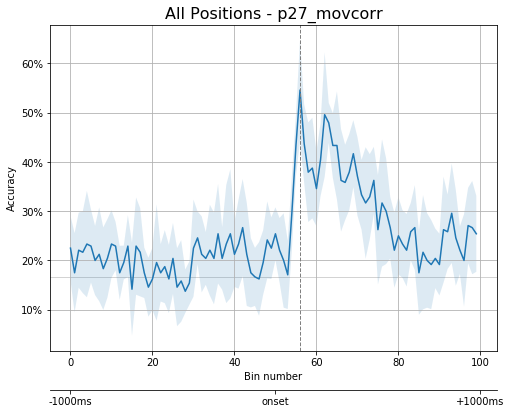

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
ax, score_means = plot_bin_scores(scores, ax)
ax.set_title('All Positions - {}'.format(participant), 
             fontsize=16)
ax2 = ax.twiny()
ax2.plot(range(len(score_means)), score_means, alpha=0)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.12))
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)
ax2.set_xticks([0, 50, 100])
ax2.set_xticklabels(["-1000ms", "onset", "+1000ms"])
ax.axvline(best_bin, color='grey', ls='--', lw=1)
ax.axhline(1/len(positions), color='lightgrey', lw=1, zorder=-1)

## Best Bin

In [17]:
X = np.vstack([pos_data[pos][:, best_bin, :] for pos in positions])
y = np.repeat(positions, n_trials)
y = le.transform(y)

In [18]:
# possible_cs = np.logspace(-2, 3, 6)
possible_cs = [1e-3, 1e-2, 1e-1, 1, 5, 10, 50, 1e2, 5e2, 1e3]
possible_cs = np.asarray(possible_cs)
train_scores, valid_scores = validation_curve(pipeline, X, y, 
                                              "logisticregression__C",
                                              possible_cs,
                                              cv=cvss,
                                              n_jobs=4)

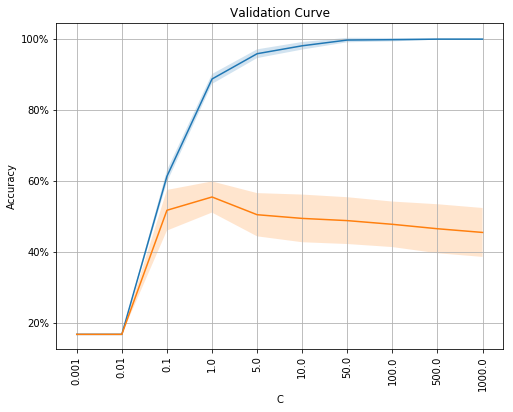

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
mean_train = train_scores.mean(axis=1)
mean_valid = valid_scores.mean(axis=1)
std_train = train_scores.std(axis=1)
std_valid = valid_scores.std(axis=1)
ax.plot(mean_train)
ax.plot(mean_valid)
x = np.arange(mean_train.size)
ax.fill_between(x, mean_train + std_train, mean_train - std_train, alpha=0.2)
ax.fill_between(x, mean_valid + std_valid, mean_valid - std_valid, alpha=0.2)
ax.set_xticks(range(possible_cs.size))
_ = ax.set_xticklabels(possible_cs, rotation=90)
ax.set_title('Validation Curve')
ax.set_ylabel('Accuracy')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
ax.set_xlabel('C')
ax.grid()

In [20]:
train_sizes, train_scores, valid_scores = learning_curve(
    pipeline, 
    X, y, 
    train_sizes=np.linspace(.4, 1., num=10), 
    cv=cvss,
    n_jobs=10
)

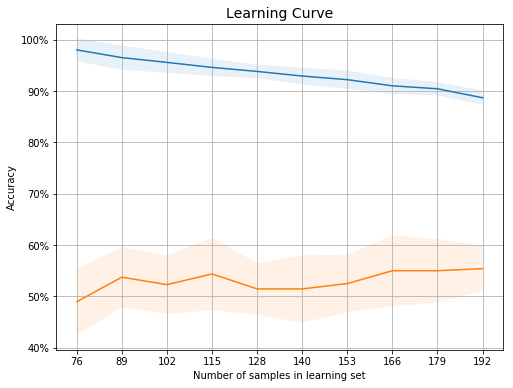

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
valid_mean = valid_scores.mean(axis=1)
valid_std = valid_scores.std(axis=1)
x = range(train_sizes.size)
ax.plot(x, train_mean)
ax.fill_between(x, train_mean + train_std, train_mean - train_std, alpha=0.1)
ax.plot(x, valid_scores.mean(axis=1))
ax.fill_between(x, valid_mean + valid_std, valid_mean - valid_std, alpha=0.1)
ax.set_xticks(x)
_ = ax.set_xticklabels(train_sizes)
ax.set_title('Learning Curve', fontsize=14)
ax.set_ylabel('Accuracy')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
ax.set_xlabel('Number of samples in learning set')
ax.grid()

## Look at the prediction

In [22]:
y_pred = cross_val_predict(pipeline, X, y, cv=cvsk, n_jobs=4)

In [23]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.53      0.60      0.56        40
          1       0.72      0.70      0.71        40
          2       0.41      0.35      0.38        40
          3       0.57      0.65      0.60        40
          4       0.62      0.62      0.62        40
          5       0.39      0.35      0.37        40

avg / total       0.54      0.55      0.54       240



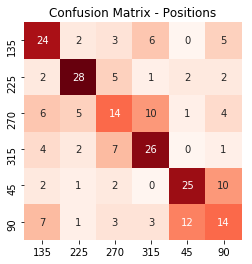

In [24]:
ax = sns.heatmap(pd.DataFrame(confusion_matrix(le.inverse_transform(y), 
                              le.inverse_transform(y_pred)),
            columns=le.classes_, index=le.classes_),
            annot=True, cmap=plt.cm.Reds, cbar=False,
            square=True)
ax.set_title('Confusion Matrix - Positions')

## Collapsing Visual Hemifields

In [47]:
collapsed_positions = ['45', '90', '135', '225', '270', '315']

In [48]:
X = np.vstack([pos_data[pos][:, best_bin, :] for pos in collapsed_positions])
y = np.repeat([-1, 1], n_trials * 3)
# y = le.transform(y)

In [49]:
y_pred = cross_val_predict(pipeline, X, y, cv=cvsk, n_jobs=4)

In [50]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

         -1       0.86      0.80      0.83       120
          1       0.81      0.87      0.84       120

avg / total       0.83      0.83      0.83       240



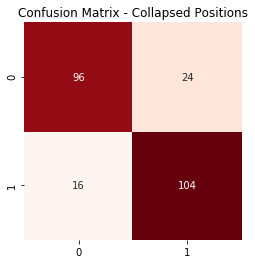

In [51]:
ax = sns.heatmap(confusion_matrix(y, 
                              y_pred),
            annot=True, cmap=plt.cm.Reds, cbar=False,
            square=True, fmt='')
ax.set_title('Confusion Matrix - Collapsed Positions')

In [52]:
for tr, te in cvsk.split(X, y):
    X_tr = X[tr]
    y_tr = y[tr]
    X_te = X[te]
    y_te = y[te]
    pipeline.fit(X_tr, y_tr)
    y_pred = pipeline.predict(X_te)
    break

lp = pipeline.named_steps['logisticregression']

In [53]:
sensor_names[np.where(lp.coef_[0] != 0)]

Index(['MEG1542', 'MEG1622', 'MEG1632', 'MEG1643', 'MEG1723', 'MEG1731',
       'MEG1732', 'MEG1741', 'MEG1812', 'MEG1813', 'MEG1832', 'MEG1833',
       'MEG1923', 'MEG1933', 'MEG1942', 'MEG2033', 'MEG2043', 'MEG2112',
       'MEG2212', 'MEG2213', 'MEG2222', 'MEG2223', 'MEG2242', 'MEG2243',
       'MEG2311', 'MEG2323', 'MEG2342', 'MEG2411', 'MEG2421', 'MEG2432',
       'MEG2433', 'MEG2512', 'MEG2611', 'MEG2612', 'MEG2622', 'MEG2643'],
      dtype='object', name=0)

In [54]:
y = np.repeat(['L', 'R'], n_trials * 3)
y = le.fit_transform(y)
for b in range(bins_per_trial):
    X = np.vstack([pos_data[pos][:, b, :] for pos in positions])
    this_bin_scores = cross_val_score(pipeline, X, y, cv=cvsk, n_jobs=4)
    bin_scores[b] = this_bin_scores

In [55]:
scores = pd.melt(pd.DataFrame(bin_scores), var_name="bin", value_name="acc")

In [56]:
sorted_scores = (scores
                 .groupby(by="bin", as_index=False)
                 .mean()
                 .sort_values(by='acc', ascending=False)
                 .head(10)
                )

In [57]:
sorted_scores

bin       acc
62   62  0.883333
63   63  0.854167
66   66  0.850000
67   67  0.845833
69   69  0.841667
56   56  0.833333
65   65  0.829167
64   64  0.829167
58   58  0.829167
57   57  0.825000

In [58]:
best_bin = sorted_scores.bin.iloc[0]

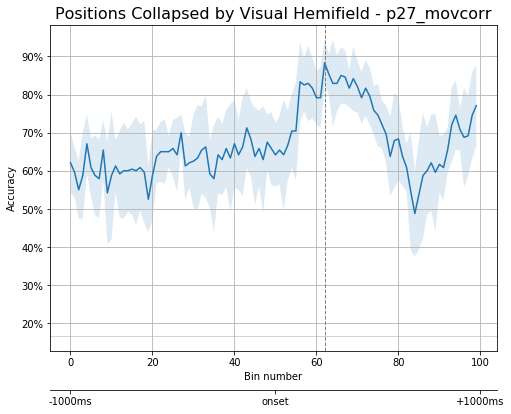

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))
ax, score_means = plot_bin_scores(scores, ax)
ax.set_title('Positions Collapsed by Visual Hemifield - {}'.format(participant), 
             fontsize=16)
ax2 = ax.twiny()
ax2.plot(range(len(score_means)), score_means, alpha=0)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.12))
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)
ax2.set_xticks([0, 50, 100])
ax2.set_xticklabels(["-1000ms", "onset", "+1000ms"])
ax.axvline(best_bin, color='grey', ls='--', lw=1)
ax.axhline(1/len(positions), color='lightgrey', lw=1, zorder=-1)
fig.savefig('positions_visualhemifield-{}'.format(participant), 
            dpi=150, transparent=True, bbox_inches='tight')

## By Distance

In [37]:
distance_positions = ['45', '315', '90', '270', '135', '225']

In [38]:
X = np.vstack([pos_data[pos][:, best_bin, :] for pos in distance_positions])
y = np.repeat(['Proximal', 'Medial', 'Distal'], n_trials * 2)

In [39]:
y = le.fit_transform(y)

In [40]:
y_pred = cross_val_predict(pipeline, X, y, cv=cvsk, n_jobs=4)

In [41]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.57      0.64      0.60        80
          1       0.43      0.41      0.42        80
          2       0.53      0.50      0.52        80

avg / total       0.51      0.52      0.51       240



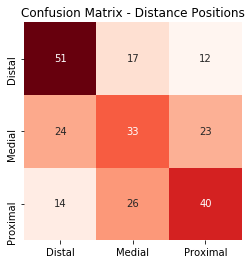

In [42]:
ax = sns.heatmap(pd.DataFrame(confusion_matrix(le.inverse_transform(y), 
                              le.inverse_transform(y_pred)),
            columns=le.classes_, index=le.classes_),
            annot=True, cmap=plt.cm.Reds, cbar=False,
            square=True, fmt='')
ax.set_title('Confusion Matrix - Distance Positions')

In [43]:
for tr, te in cvsk.split(X, y):
    X_tr = X[tr]
    y_tr = y[tr]
    X_te = X[te]
    y_te = y[te]
    pipeline.fit(X_tr, y_tr)
    y_pred = pipeline.predict(X_te)
    break

lp = pipeline.named_steps['logisticregression']

In [44]:
sensor_names[np.where(lp.coef_[0] != 0)]

Index(['MEG1522', 'MEG1542', 'MEG1611', 'MEG1612', 'MEG1623', 'MEG1632',
       'MEG1633', 'MEG1642', 'MEG1643', 'MEG1713', 'MEG1742', 'MEG1812',
       'MEG1822', 'MEG1832', 'MEG1833', 'MEG1842', 'MEG1942', 'MEG1943',
       'MEG2012', 'MEG2023', 'MEG2132', 'MEG2141', 'MEG2212', 'MEG2213',
       'MEG2242', 'MEG2243', 'MEG2313', 'MEG2322', 'MEG2323', 'MEG2343',
       'MEG2413', 'MEG2423', 'MEG2431', 'MEG2441', 'MEG2522', 'MEG2523',
       'MEG2611', 'MEG2612', 'MEG2613'],
      dtype='object', name=0)

In [45]:
sensor_names[np.where(lp.coef_[1] != 0)]

Index(['MEG1522', 'MEG1542', 'MEG1622', 'MEG1623', 'MEG1633', 'MEG1642',
       'MEG1643', 'MEG1723', 'MEG1742', 'MEG1813', 'MEG1822', 'MEG1823',
       'MEG1832', 'MEG1943', 'MEG2011', 'MEG2012', 'MEG2013', 'MEG2112',
       'MEG2113', 'MEG2133', 'MEG2141', 'MEG2143', 'MEG2222', 'MEG2223',
       'MEG2242', 'MEG2312', 'MEG2313', 'MEG2323', 'MEG2342', 'MEG2412',
       'MEG2413', 'MEG2422', 'MEG2432', 'MEG2433', 'MEG2441', 'MEG2513',
       'MEG2523', 'MEG2543', 'MEG2613', 'MEG2622', 'MEG2623', 'MEG2642'],
      dtype='object', name=0)

In [46]:
sensor_names[np.where(lp.coef_[2] != 0)]

Index(['MEG1522', 'MEG1532', 'MEG1543', 'MEG1621', 'MEG1622', 'MEG1623',
       'MEG1641', 'MEG1642', 'MEG1723', 'MEG1812', 'MEG1822', 'MEG1823',
       'MEG1833', 'MEG1842', 'MEG1913', 'MEG1923', 'MEG1942', 'MEG2043',
       'MEG2113', 'MEG2143', 'MEG2212', 'MEG2213', 'MEG2232', 'MEG2233',
       'MEG2243', 'MEG2322', 'MEG2411', 'MEG2413', 'MEG2422', 'MEG2431',
       'MEG2432', 'MEG2442', 'MEG2443', 'MEG2512', 'MEG2513', 'MEG2522',
       'MEG2523', 'MEG2543', 'MEG2611', 'MEG2612', 'MEG2622'],
      dtype='object', name=0)